# Refactored notebook for modelling

## imports

In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns

## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
17474,RBZ,Hip Replacement,0,2016/17,70 to 79,2.0,2,0,2,2,...,4,4,3,4,1,4,4,4,44.0,40.982845
4888,NT242,Hip Replacement,0,2016/17,70 to 79,1.0,2,0,3,2,...,3,4,4,4,4,4,4,4,47.0,38.347805
19708,RW6,Hip Replacement,0,2019/20,70 to 79,2.0,2,0,2,2,...,1,0,2,4,1,2,2,2,23.0,36.398392


## basic cleaning

In [3]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

In [4]:
%%time
df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name]))
    .apply(lambda s: map_labels(s, **hip_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    #     .replace("missing", np.nan)
)

df_hip_clean.sample(3)

CPU times: user 801 ms, sys: 65.4 ms, total: 867 ms
Wall time: 891 ms


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
2242,April 2019 - April 2020,NaN,NaN,no,1 to 5 years,no,alone,yes,missing,missing,...,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,43.0
4794,April 2016 - April 2017,70 to 79,male,yes,1 to 5 years,no,with partner / spouse / family / friends,no,missing,missing,...,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,47.0
19571,April 2018 - April 2019,70 to 79,male,no,6 to 10 years,no,with partner / spouse / family / friends,yes,missing,missing,...,sometimes or just at first,sometimes or just at first,sometimes or just at first,most of the time,sometimes or just at first,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,32.0


## split data

In [5]:
#split train + test set
# df_knee_seen = df_knee_clean.query("t0_year != '2019/20'")
# df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

df_hip = df_hip_clean.query("t0_year != '2019/20'")
df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

df_hip.sample(3)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
9889,April 2016 - April 2017,80 to 89,female,yes,1 to 5 years,no,with partner / spouse / family / friends,no,missing,missing,...,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,44.0
9993,April 2019 - April 2020,70 to 79,female,no,6 to 10 years,no,with partner / spouse / family / friends,yes,missing,yes,...,"often, not just at first","often, not just at first","often, not just at first",sometimes or just at first,most of the time,all of the time,"often, not just at first",sometimes or just at first,"often, not just at first",24.0
15248,April 2018 - April 2019,70 to 79,female,no,1 to 5 years,no,alone,no,missing,yes,...,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,rarely/never,47.0


## create delta dataframes

In [6]:
df_org = df_hip_clean.apply(
    lambda s: map_labels(s, backwards=True, **hip_meta[s.name])
).apply(np.asarray)

# df_knee_delta = method_delta(df_knee_train)
df_hip_delta = method_delta(df_org)

# now you could join them again with the original df ...
# eg: df_hip_clean.join(df_hip_delta)
df_hip_clean = df_hip_clean.join(df_hip_delta)
df_hip_clean.sample(5)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,delta_ohs_pain,delta_ohs_score,delta_ohs_shopping,delta_ohs_stairs,delta_ohs_standing,delta_ohs_sudden_pain,delta_ohs_transport,delta_ohs_walking,delta_ohs_washing,delta_ohs_work
18742,April 2019 - April 2020,70 to 79,female,no,6 to 10 years,no,alone,yes,yes,missing,...,4,19.0,0,0,2,2,1,2,0,2
21670,April 2016 - April 2017,60 to 69,female,no,less than 1 year,no,alone,yes,missing,missing,...,4,34.0,3,3,3,3,2,0,3,4
9521,April 2017 - April 2018,80 to 89,female,no,less than 1 year,no,alone,yes,missing,yes,...,3,30.0,3,2,3,3,1,4,2,1
18893,April 2017 - April 2018,80 to 89,female,no,6 to 10 years,no,alone,yes,missing,missing,...,4,28.0,2,2,3,3,1,1,1,3
35169,April 2016 - April 2017,70 to 79,male,no,1 to 5 years,no,with partner / spouse / family / friends,yes,yes,yes,...,3,20.0,0,2,1,1,2,2,1,2


In [7]:
df_hip_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476485 entries, 0 to 44240
Data columns (total 91 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_year                 476485 non-null  category
 1   t0_age_band             427774 non-null  category
 2   t0_gender               427774 non-null  category
 3   t0_assisted             476485 non-null  category
 4   t0_symptom_period       476485 non-null  category
 5   t0_previous_surgery     476485 non-null  category
 6   t0_living_arrangements  476485 non-null  category
 7   t0_disability           476485 non-null  category
 8   t0_heart_disease        476485 non-null  category
 9   t0_high_bp              476485 non-null  category
 10  t0_stroke               476485 non-null  category
 11  t0_circulation          476485 non-null  category
 12  t0_lung_disease         476485 non-null  category
 13  t0_diabetes             476485 non-null  category
 14  t0_ki

## Make feature set

In [8]:
# print(len(df_hip), "original")
print(len(df_hip.dropna()), "after possible total dropna")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

103346 after possible total dropna


t0_age_band          0.089507
t0_gender            0.089507
t0_eqvas_score       0.089385
t0_eq5d_score        0.056014
t1_eqvas_score       0.047734
t1_eq5d_score        0.042082
t0_ohs_score         0.010959
t1_ohs_score         0.010908
t0_eq5d_mobility     0.000000
t0_eq5d_self_care    0.000000
dtype: float64

In [9]:
# remove NaNs from non categorical/ordinal columns (numerical)
print(len(df_hip), "original")
num_cols = df_hip.select_dtypes(exclude="category").columns
df_hip = df_hip.dropna(subset=num_cols)

print(len(df_hip), "after dropna on numerical")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
113818 after dropna on numerical


t0_age_band           0.092007
t0_gender             0.092007
t1_ohs_score          0.000000
t1_assisted           0.000000
t0_eq5d_mobility      0.000000
t0_eq5d_self_care     0.000000
t0_eq5d_activity      0.000000
t0_eq5d_discomfort    0.000000
t0_eq5d_anxiety       0.000000
t0_eq5d_score         0.000000
dtype: float64

In [10]:
# # Buggy: TO DO ...
# # s = df_hip["t0_age_band"]

# # def fillna(s, value):
# #     if s.dtype == "category":
# #         print("is cat")
# #         if value not in s.dtype.categories:
# #             print(value, "not in cats")
# #             display(s.dtype)
# #             display(s.dtype.add_categories(value))
# #             s.add_categories(value, inplace=True)
# #             display(s.dtype)
# #     return s.fillna(value)

# # fillna(s, "missing")

# # status before
# display((df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10))
# print(len(df_hip), "original")

# # remove NaNs from non categorical/ordinal columns (numerical)
# num_cols = df_hip.select_dtypes(include="number").columns
# df_hip = df_hip.dropna(subset=num_cols).fillna("missing")
# print(len(df_hip), "after dropna on numerical")

## Create Y

### First Y: success anchor for OHS

In [11]:
df_hip_clean['t1_success'].value_counts()

much better        412751
a little better     37004
about the same       9882
missing              6851
a little worse       5559
much worse           4438
Name: t1_success, dtype: int64

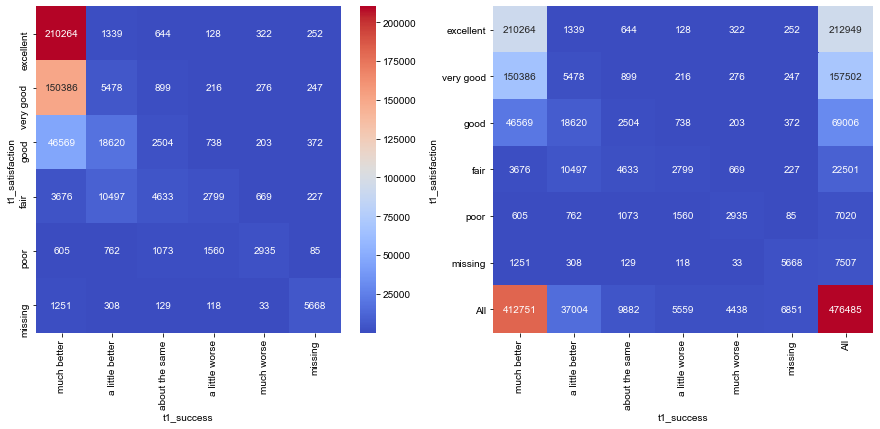

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(pd.crosstab([df_hip_clean["t1_satisfaction"]], [df_hip_clean["t1_success"]]), cmap="coolwarm", annot=True, cbar=True, fmt='g', ax=ax[0])
sns.heatmap(pd.crosstab([df_hip_clean["t1_satisfaction"]], [df_hip_clean["t1_success"]], margins=True), cmap='coolwarm', annot=True, fmt='g', cbar=False, ax=ax[1])
sns.set(font_scale=1.5)

In [13]:
def success_rec(recode):
    if recode == 'a little worse':
        return 1
    elif recode == 'much worse':
        return 1
#     elif recode == 'about the same':
#         return 1
    else:
        return 0
    
df_hip_clean['success_recode'] = df_hip_clean['t1_success'].apply(success_rec)
df_hip_clean['success_recode'].value_counts(sort=False)

0    466488
1      9997
Name: success_recode, dtype: int64

<Figure size 1080x576 with 0 Axes>

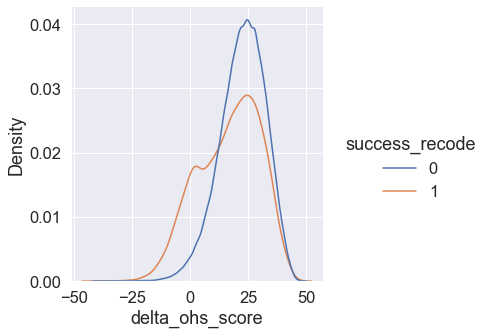

In [14]:
plt.figure(figsize=(15,8))
sns.displot(df_hip_clean, x="delta_ohs_score", hue='success_recode', alpha=.5, kind="kde", common_norm=False);

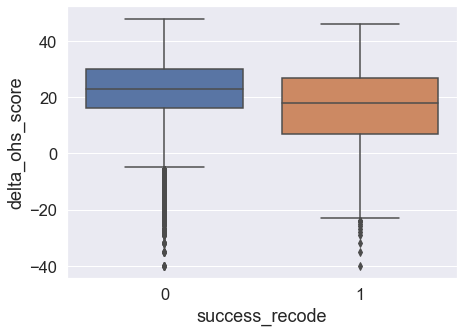

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_hip_clean["success_recode"], y=df_hip_clean['delta_ohs_score'], data=df_hip_clean)

In [16]:
df_hip_clean['diff_ohs'] = df_hip_clean['t1_ohs_score'] - df_hip_clean['t0_ohs_score']

In [24]:
df_hip_clean['REL_diff_ohs'] = (df_hip_clean['diff_ohs'] / df_hip_clean['t0_ohs_score'])
df_hip_clean.describe()

,t0_eq5d_score,t1_eq5d_score,t0_eqvas_score,t1_eqvas_score,t0_ohs_score,t1_ohs_score,delta_eq5d_activity,delta_eq5d_anxiety,delta_eq5d_discomfort,delta_eq5d_mobility,...,delta_ohs_stairs,delta_ohs_standing,delta_ohs_sudden_pain,delta_ohs_transport,delta_ohs_walking,delta_ohs_washing,delta_ohs_work,success_recode,diff_ohs,REL_diff_ohs
count,449559.000000,456700.000000,433667.000000,453886.000000,471275.000000,471386.000000,476485.000000,476485.000000,476485.000000,476485.000000,...,476485.000000,476485.000000,476485.000000,476485.000000,476485.000000,476485.000000,476485.000000,476485.000000,466320.000000,4.663200e+05
mean,0.344635,0.805906,63.665252,77.817741,17.620415,40.119644,-0.784789,-0.394783,-1.064371,-0.639628,...,1.460199,1.787930,2.125847,1.516984,1.580805,1.332890,2.100687,0.020981,22.478149,inf
std,0.321647,0.237274,22.400781,17.650879,8.071167,8.413555,1.756134,1.905852,1.897647,1.728203,...,1.337954,1.325185,1.597263,1.260686,1.580289,1.129417,1.417239,0.143320,9.883778,NaN
min,-0.594000,-0.594000,0.000000,0.000000,0.000000,0.000000,-8.000000,-8.000000,-8.000000,-8.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,0.000000,-40.000000,-1.000000e+00
25%,0.055000,0.691000,50.000000,70.000000,12.000000,36.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,16.000000,7.333333e-01
50%,0.516000,0.848000,70.000000,80.000000,17.000000,43.000000,-1.000000,0.000000,-1.000000,-1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,0.000000,23.000000,1.333333e+00
75%,0.656000,1.000000,80.000000,90.000000,23.000000,47.000000,0.000000,0.000000,-1.000000,0.000000,...,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,0.000000,30.000000,2.363636e+00
max,1.000000,1.000000,100.000000,100.000000,48.000000,48.000000,8.000000,8.000000,8.000000,8.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,48.000000,inf


In [28]:
df_hip_clean['REL_diff_ohs'].replace([np.inf, -np.inf], np.nan)

0        0.894737
0        0.894737
0        0.894737
0        0.894737
0        0.629630
           ...   
44236    0.370370
44237   -0.052632
44238    0.869565
44239    1.047619
44240    2.615385
Name: REL_diff_ohs, Length: 476485, dtype: float32

In [42]:
df_hip_clean['REL_diff_ohs1'] = df_hip_clean['REL_diff_ohs'].replace([np.inf, -np.inf], np.nan).dropna(axis=1)

ValueError: No axis named 1 for object type Series

In [37]:
yscaler = ['t0_ohs_score', 'REL_diff_ohs']

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_hip_clean[yscaler] = scaler.fit_transform(df_hip_clean[yscaler])

ValueError: Input contains infinity or a value too large for dtype('float32').

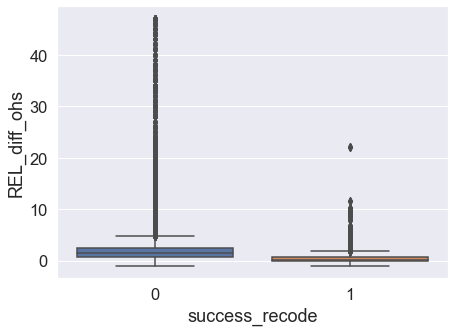

In [34]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_hip_clean["success_recode"], y=df_hip_clean['REL_diff_ohs'], data=df_hip_clean)

In [ ]:
plt.figure(figsize=(15,8))
sns.displot(df_hip_clean, x="diff_ohs", hue='success_recode', alpha=.5, kind="kde", common_norm=False);

In [ ]:
sns.pairplot(data=df_hip_clean[['t0_ohs_score','t1_ohs_score', 'success_recode']],hue='success_recode', palette="coolwarm", corner=True);

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_hip_clean["success_recode"], y=df_hip_clean['diff_ohs'], data=df_hip_clean)

In [ ]:
df_hip_clean['diff_ohs'].groupby(df_hip_clean['success_recode']).mean()

In [ ]:
# def success_rec(recode):
#     if recode == 'a little worse':
#         return 1
#     elif recode == 'much worse':
#         return 1
# #     elif recode == 'about the same':
# #         return 1
#     else:
#         return 0
    
# df_hip['success_recode'] = df_hip['t1_success'].apply(success_rec)
# df_hip['success_recode'].value_counts(sort=False)

In [ ]:
df_hip = df_hip.dropna().sample(10_000) # dirty drop for the sake of testing pl

# create x, y
X = df_hip.filter(regex="t0")
y = (df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"] <= 3).astype(int) # hip <= 3
# y = (df_hip["success_recode"] == 1).astype(int) # hip <= 3

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

## show OHE

In [ ]:
# example to show it works
OHE = OneHotEncoder(sparse=False, dtype="uint8")
OHE.fit(X_train)

pd.DataFrame(
    data=OHE.transform(X_train),
    index=X_train.index,
    columns=OHE.get_feature_names(X_train.columns),
)

## make balanced

In [ ]:
print("before:")
display(y_train.value_counts())

cat_cols = X_train.dtypes == "category"

resampler = SMOTENC(categorical_features=cat_cols.values)
X_train_balanced, y_train_balanced = resampler.fit_resample(X_train, y_train)

print("after:")
display(y_train_balanced.value_counts())

## make + train a simple pipeline

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# make the pipeline
ct = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include="category")),
    (StandardScaler(), make_column_selector(dtype_include="number")),
) 

pl = make_pipeline(ct, AdaBoostClassifier())

# train the pipeline/model
pl.fit(X_train_balanced, y_train_balanced)

## predict + evaluate

In [ ]:
# make prediction
y_hat = pl.predict(X_test.head(500))

# evaluate
print(classification_report(y_test.head(500), y_hat))

## extract feature names pl

In [ ]:
# get the feature names from pipeline
def get_feature_names(sklobj, feature_names=[]):

    if isinstance(sklobj, Pipeline):
        for name, step in sklobj.steps:
            get_feature_names(step, feature_names)
    elif isinstance(sklobj, ColumnTransformer):
        for name, transformer, columns in sklobj.transformers_:
            feature_names += get_feature_names(transformer, columns)
    elif isinstance(sklobj, OneHotEncoder):
        feature_names = sklobj.get_feature_names(feature_names).tolist()
    elif isinstance(sklobj, str):
        if sklobj == "passthrough":
            pass
        elif sklobj == "drop":
            feature_names = []
            
    return feature_names

In [ ]:
get_feature_names(pl)

In [ ]:
# # this is slow ...
# r = permutation_importance(pl, X_train.head(1_000), y_train.head(1_000), n_repeats=2, random_state=0)

# feature_names = get_feature_names(pl)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

## a more advanced pipeline

In [ ]:
# TO DO ...

## debug issue

In [ ]:
data = list("abcebdebca")
categories = list("abcd")

In [ ]:
cats = pd.Categorical(data, categories=categories, ordered=True)
s1 = pd.Series(cats)

display(s1)
s1.cat.categories

In [ ]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=categories, ordered=True)
s2 = pd.Series(data).astype(cat_type)

display(s2)
s2.cat.categories

In [ ]:
s3 = pd.Series(data).astype("category")

display(s3)
s3.cat.categories